<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPoseKit Step 3 - Train a model

This is step 3 of the example notebooks for using DeepPoseKit. This notebook shows you how to use your annotated data to train a deep learning model applying data augmentation and using callbacks for logging the training process and saving the best model during training.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

If you're using Colab make sure to go to the “Runtime” dropdown menu, select “change runtime type” and select GPU in the hardware accelerator drop-down menu

If you haven't already installed DeepPoseKit you can run the next cell

In [1]:
import sys
!{sys.executable} -m pip install git+https://github.com/jgraving/deepposekit 

  Cloning https://github.com/jgraving/deepposekit to /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-mfglvbk0
  Running command git clone -q https://github.com/jgraving/deepposekit /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-mfglvbk0
  Stored in directory: /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-ephem-wheel-cache-l2pf4dpp/wheels/af/2f/a1/97dbc668c1928ad2c177b380a22ec38f854b19fac8399b0846
Successfully built deepposekit
  Found existing installation: deepposekit 0.3.0.dev0
    Uninstalling deepposekit-0.3.0.dev0:
      Successfully uninstalled deepposekit-0.3.0.dev0


In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/

Use the next cell to download the example data into your home directory

In [3]:
!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

Cloning into '/Users/jake/deepposekit-data'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 61 (delta 13), reused 21 (delta 2), pack-reused 29
Unpacking objects: 100% (61/61), done.


There are a few example datasets to choose from:

In [2]:
glob.glob(HOME + '/deepposekit-data/**/**/*annotation*.h5')

['/Users/jake/deepposekit-data/datasets/fly/example_annotation_set.h5',
 '/Users/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 '/Users/jake/deepposekit-data/datasets/locust/annotation_data_release.h5',
 '/Users/jake/deepposekit-data/datasets/zebra/annotation_data_release.h5']

# Create a `DataGenerator`
This creates a `DataGenerator` for loading annotated data. You can also look at the doc string for more explanation:


In [3]:
DataGenerator?

In [4]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5')

/usr/local/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

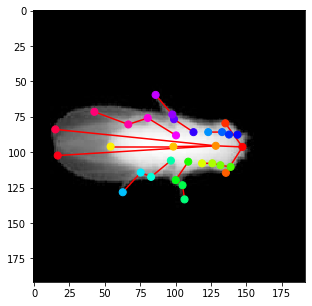

In [5]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create an augmentation pipeline
DeepPoseKit works with augmenters from the [imgaug package](https://github.com/aleju/imgaug).
This is a short example using spatial augmentations with axis flipping and affine transforms
See https://github.com/aleju/imgaug for more documentation on augmenters.

`deepposekit.augment.FlipAxis` takes the `DataGenerator` as an argument to get the keypoint swapping information defined in the annotation set. When the images are mirrored keypoints for left and right sides are swapped to avoid "confusing" the model during training.

In [6]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


Load an image-keypoints pair, apply augmentation, visualize it. Rerun this cell to see multiple random augmentations.

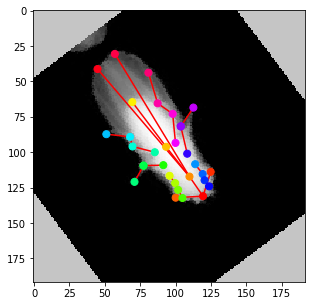

In [7]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create a `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [8]:
TrainingGenerator?

In [9]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 1350,
 'n_validation': 150,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (24, 24),
 'n_output_channels': 66,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': '/Users/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 1500,
 'image_shape': (192, 192, 1),
 'keypoints_shape': (32, 2)}

# Check the `TrainingGenerator` output
This plots the training data output from the `TrainingGenerator` to ensure that the augmentation is working and the confidence maps look good. Rerun this cell to see random augmentations. 

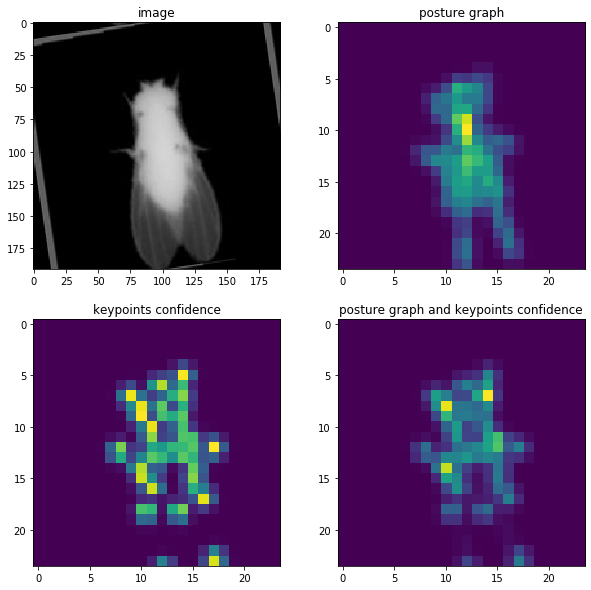

In [10]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. The `DeepLabCut` model has multiple pretrained (on ImageNet) backbones available for using transfer learning, including the original ResNet50 as well as the faster MobileNetV2 and DenseNet121. Right now this notebook is being run on a CPU, so we'll select `StackedDenseNet` and set `n_stacks=1` for 1 hourglass, with `growth_rate=32` (32 filters per convolution block) for a small number of filters. Increase the `growth_rate` and/or `n_stacks` to improve model performance. `DeepLabCut` with `backbone="mobilenetv2"` is also fast on CPU. All the models run much faster on a GPU

In [11]:
from deepposekit.models import DeepLabCut, StackedDenseNet, LEAP

You can also look at the doc strings for any of the models to get more information:

In [ ]:
StackedDenseNet?

In [ ]:
DeepLabCut?

In [12]:
model = StackedDenseNet(train_generator, n_stacks=1, growth_rate=32, n_transitions=-1)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
model.get_config()

W0929 10:22:01.990450 4656326080 deprecation.py:323] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/keras/backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0929 10:22:02.542437 4656326080 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


{'name': 'StackedDenseNet',
 'n_stacks': 1,
 'n_transitions': 6,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'subpixel': True,
 'n_train': 1350,
 'n_validation': 150,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (24, 24),
 'n_output_channels': 66,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': '/Users/jake/deepposekit-data/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 1500,
 'image_shape': (192, 192, 1),
 'keypoints_shape': (32, 2)}

# Test the prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations. This was run on the CPU so it's a bit slow, but is much faster on the GPU

In [13]:
data_size = (100,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
t0 = time.time()
y = model.predict(x, batch_size=10, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

100/100 [==============================] - 3s 34ms/sample
29.367056275916614


# Define callbacks to enhance model training
Here you can define callbacks to pass to the model for use during training. You can use any callbacks available in `deepposekit.callbacks` or `tensorflow.keras.callbacks`

Remember, if you set `validation_split=0` for your `TrainingGenerator`, which will just use the training set for model fitting, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.


`Logger` evaluates the validation set (or training set if `validation_split=0` in the `TrainingGenerator`) at the end of each epoch and saves the evaluation data to a HDF5 log file (if `filepath` is set).

In [14]:
logger = Logger(validation_batch_size=10
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training.

In [15]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually. Set `optimizer=True` if you wish to resume training from a saved model, otherwise saving and loading are faster if `optimizer=False`.


In [17]:
model_checkpoint = ModelCheckpoint(
    HOME + "/deepposekit-data/datasets/fly/best_model_densenet.h5",
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
    optimizer=True, # Set this to True if you wish to resume training from a saved model
)

`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment.

In [18]:
early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

Create a list of callbacks to pass to the model

In [19]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

# Fit the model

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset.

The number of `epochs` is set to `epochs=5` for demonstration purposes. **Increase the number of epochs to train the model longer, for example `epochs=1000`**. The `EarlyStopping` callback will then automatically end training if there is no improvement. See the doc string for details:

In [ ]:
model.fit?

In [20]:
model.fit(
    batch_size=5,
    validation_batch_size=10,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=5,
    n_workers=8,
    steps_per_epoch=None,
)

/usr/local/lib/python3.7/site-packages/deepposekit/models/engine.py:135: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/5
269/270 [============================>.] - ETA: 0s - loss: 236.8005 - output_0_loss: 128.9632 - output_1_loss: 107.8372
Epoch 00001: val_loss improved from inf to 184.81545, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean: 21.11 (0%:  0.08, 5%:  1.51, 25%:  4.29, 50%: 12.26, 75%: 32.18, 95%: 62.36, 100%: 119.84) 
confidence - mean:  0.16 (0%:  0.03, 5%:  0.04, 25%:  0.10, 50%:  0.14, 75%:  0.18, 95%:  0.34, 100%:  0.53) 

270/270 [==============================] - 103s 383ms/step - loss: 236.6388 - output_0_loss: 128.8693 - output_1_loss: 107.7695 - val_loss: 184.8155 - val_output_0_loss: 100.5255 - val_output_1_loss: 84.2899
Epoch 2/5
269/270 [============================>.] - ETA: 0s - loss: 178.0710 - output_0_loss: 99.0256 - output_1_loss: 79.0454
Epoch 00002: val_loss improved from 184.81545 to 153.05717, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_metri

# Load the model and resume training

This loads the saved model and passes it the augmentation pipeline and `DataGenerator` from earlier.

In [21]:
model = load_model(
    HOME + "/deepposekit-data/datasets/fly/best_model_densenet.h5",
    augmenter=augmenter,
    generator=data_generator,
)

W0929 10:31:25.760160 4656326080 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 10:31:25.772601 4656326080 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 10:31:25.774595 4656326080 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.

To resume training, simply call `model.fit` again. We'll run it for another 30 `epochs`

In [22]:
model.fit(
    batch_size=5,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=30,
    n_workers=8,
    steps_per_epoch=None,
)

Epoch 1/30
269/270 [============================>.] - ETA: 0s - loss: 121.3339 - output_0_loss: 79.7548 - output_1_loss: 41.5791
Epoch 00001: val_loss improved from 114.22691 to 104.32965, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  4.12 (0%:  0.04, 5%:  0.54, 25%:  1.35, 50%:  2.17, 75%:  3.65, 95%: 11.59, 100%: 143.08) 
confidence - mean:  0.58 (0%:  0.05, 5%:  0.30, 25%:  0.48, 50%:  0.60, 75%:  0.70, 95%:  0.81, 100%:  1.02) 

270/270 [==============================] - 106s 394ms/step - loss: 121.3312 - output_0_loss: 79.7473 - output_1_loss: 41.5839 - val_loss: 104.3296 - val_output_0_loss: 71.4908 - val_output_1_loss: 32.8388
Epoch 2/30
269/270 [============================>.] - ETA: 0s - loss: 114.7393 - output_0_loss: 76.2748 - output_1_loss: 38.4645
Epoch 00002: val_loss improved from 104.32965 to 103.56771, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_me

Epoch 13/30
269/270 [============================>.] - ETA: 0s - loss: 82.8562 - output_0_loss: 54.9450 - output_1_loss: 27.9112
Epoch 00013: val_loss improved from 75.83860 to 73.57035, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  2.72 (0%:  0.04, 5%:  0.47, 25%:  1.08, 50%:  1.73, 75%:  2.76, 95%:  7.67, 100%: 93.38) 
confidence - mean:  0.66 (0%:  0.04, 5%:  0.35, 25%:  0.57, 50%:  0.69, 75%:  0.78, 95%:  0.90, 100%:  1.04) 

270/270 [==============================] - 110s 406ms/step - loss: 82.8141 - output_0_loss: 54.9244 - output_1_loss: 27.8897 - val_loss: 73.5703 - val_output_0_loss: 50.0395 - val_output_1_loss: 23.5308
Epoch 14/30
269/270 [============================>.] - ETA: 0s - loss: 81.9819 - output_0_loss: 54.2365 - output_1_loss: 27.7454
Epoch 00014: val_loss improved from 73.57035 to 72.85951, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_metrics: 

Epoch 25/30
269/270 [============================>.] - ETA: 0s - loss: 69.9028 - output_0_loss: 45.3226 - output_1_loss: 24.5803
Epoch 00025: val_loss did not improve from 59.95037
evaluation_metrics: 
euclidean - mean:  2.45 (0%:  0.00, 5%:  0.43, 25%:  1.02, 50%:  1.58, 75%:  2.47, 95%:  6.38, 100%: 92.61) 
confidence - mean:  0.70 (0%:  0.04, 5%:  0.42, 25%:  0.61, 50%:  0.72, 75%:  0.81, 95%:  0.93, 100%:  1.08) 

270/270 [==============================] - 107s 398ms/step - loss: 69.8766 - output_0_loss: 45.3138 - output_1_loss: 24.5628 - val_loss: 60.1880 - val_output_0_loss: 40.1136 - val_output_1_loss: 20.0744
Epoch 26/30
269/270 [============================>.] - ETA: 0s - loss: 68.6631 - output_0_loss: 44.4764 - output_1_loss: 24.1867
Epoch 00026: val_loss improved from 59.95037 to 59.24072, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  2.48 (0%:  0.00, 5%:  0.47, 25%:  1.09, 50%:  1.68, 75%:  2.55, 95%